# Visualize GRN

In [1]:
import os
import sys
from tqdm import tqdm

import tensorflow
import numpy as np
import pandas as pd
import torch
from scipy.stats import pearsonr, spearmanr, ttest_ind
from sklearn.metrics import accuracy_score
from velovi import preprocess_data, VELOVI

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
from matplotlib.colors import to_hex

import scanpy as sc
import scvelo as scv
import scvi
from scvelo.plotting.simulation import compute_dynamics

#from _calculation import get_gams
sys.path.append("../..")
from paths import DATA_DIR, FIG_DIR

2024-11-12 23:22:28.552258: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 23:22:32.762651: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-12 23:22:32.762943: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-12 23:22:32.767564: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 23:22:33.895779: I tensorflow/core/platform/cpu_feature_g

In [2]:
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2
from distributed import Client, LocalCluster

In [3]:
from regvelovi import REGVELOVI
from typing import Literal
from velovi import preprocess_data, VELOVI
import anndata

In [4]:
import scipy
import sklearn
import re

import torch.nn.functional as F
from scipy.spatial.distance import cdist

In [5]:
import networkx as nx

## General settings

In [6]:
scvi.settings.dl_pin_memory_gpu_training = False

In [7]:
plt.rcParams['svg.fonttype'] = 'none'

In [8]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map='viridis')

In [9]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / 'cell_cycle', exist_ok=True)

SAVE_DATASETS = False
if SAVE_DATASETS:
    os.makedirs(DATA_DIR / 'cell_cycle', exist_ok=True)

## Function definitions

In [10]:
def add_regvelo_outputs_to_adata(adata_raw, vae, n_samples = 30):
    latent_time = vae.get_latent_time(n_samples=n_samples, time_statistic = "mean",batch_size = adata_raw.shape[0])
    velocities = vae.get_velocity(n_samples=n_samples, velo_statistic="mean",batch_size = adata_raw.shape[0])

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:,vae.module.target_index].copy()
    
    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_regvelo"] = latent_time
    
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
    return adata

## Load datasets

In [11]:
adata = sc.read_h5ad(DATA_DIR / "cell_cycle" / "cell_cycle_processed.h5ad")

In [12]:
reg_bdata = adata.copy()
reg_bdata.uns["regulators"] = adata.var.index.values
reg_bdata.uns["targets"] = adata.var.index.values
reg_bdata.uns["skeleton"] = np.ones((len(adata.var.index),len(adata.var.index)))
reg_bdata

AnnData object with n_obs × n_vars = 1146 × 395
    obs: 'phase', 'fucci_time', 'pseudo_clusters', 'pseudo_clusters_equal_size', 'pseudo_clusters_equal_size_num', 'cell_cycle_rad', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'neighbors', 'pca', 'umap', 'velocity_params', 'regulators', 'targets', 'skeleton'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'velocity'
    obsp: 'connectivities', 'distances'

In [13]:
TF = pd.read_csv("RegVelo_datasets/cell cycle/allTFs_hg38.txt",header = None)
TF = reg_bdata.var_names[reg_bdata.var_names.isin(TF.iloc[:,0])]

## Identify most activate TF

In [14]:
reg_vae = REGVELOVI.load(DATA_DIR / "cell_cycle" / "model_1",reg_bdata)
GRN = reg_vae.module.v_encoder.GRN_Jacobian(torch.tensor(reg_bdata.layers["Ms"].mean(0)).to("cuda:0")).detach().cpu().numpy()
pd.DataFrame((GRN[:,reg_bdata.var.index.isin(TF)]).mean(0),index = reg_bdata.var.index[reg_bdata.var.index.isin(TF)]).sort_values(0,ascending=False).iloc[:10,:]

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/cell_cycle/model_1/model.pt    
         already downloaded                                                                                        


,0
TGIF1,0.006552
ETV1,0.002496
EGR1,0.001455
KLF7,0.001273
ARID5B,0.001099
ETV7,0.001047
BHLHE40,0.000140
KIF22,0.000071
EBF1,0.000038
ZSCAN4,-0.000008


## Visualize GRN

In [15]:
targets = GRN[:,[i == "TGIF1" for i in reg_bdata.var.index]].reshape(-1)
prior = 0

In [16]:
targets = pd.DataFrame(targets,index = reg_bdata.var.index)

In [17]:
targets.loc[:,"weight"] = targets.iloc[:,0].abs()
targets.loc[:,"prior"] = prior

In [18]:
GRN_visualize_tgif1 = targets.sort_values('weight',ascending=False).iloc[:50,:]

In [19]:
targets = GRN[:,[i == "ETV1" for i in reg_bdata.var.index]].reshape(-1)
prior = 0

In [20]:
targets = pd.DataFrame(targets,index = reg_bdata.var.index)

In [21]:
targets.loc[:,"weight"] = targets.iloc[:,0].abs()
targets.loc[:,"prior"] = prior

In [22]:
GRN_visualize_etv1 = targets.sort_values('weight',ascending=False).iloc[:50,:]

In [23]:
df1 = pd.DataFrame({'from':["TGIF1"]*50,
                   'to':GRN_visualize_tgif1.index.tolist(),
                   'status':GRN_visualize_tgif1.loc[:,"prior"]})

df2 = pd.DataFrame({'from':["ETV1"]*50,
                   'to':GRN_visualize_etv1.index.tolist(),
                   'status':GRN_visualize_etv1.loc[:,"prior"]})

In [24]:
df = pd.concat([df1, df2], axis=0)

In [25]:
list1 = ["TGIF1"] + GRN_visualize_tgif1.index.tolist()
list2 = ["ETV1"] + GRN_visualize_etv1.index.tolist()

# Define communities
community1 = list(set(list1) - set(list2))  # Nodes only in list1
community2 = list(set(list2) - set(list1))  # Nodes only in list2
community3 = list(set(list1).intersection(list2))  # Nodes shared by both
communities = [frozenset(set(community1)),frozenset(set(community2)),frozenset(set(community3))]

In [26]:
G = nx.from_pandas_edgelist(df,source = 'from',target='to',create_using=nx.DiGraph())

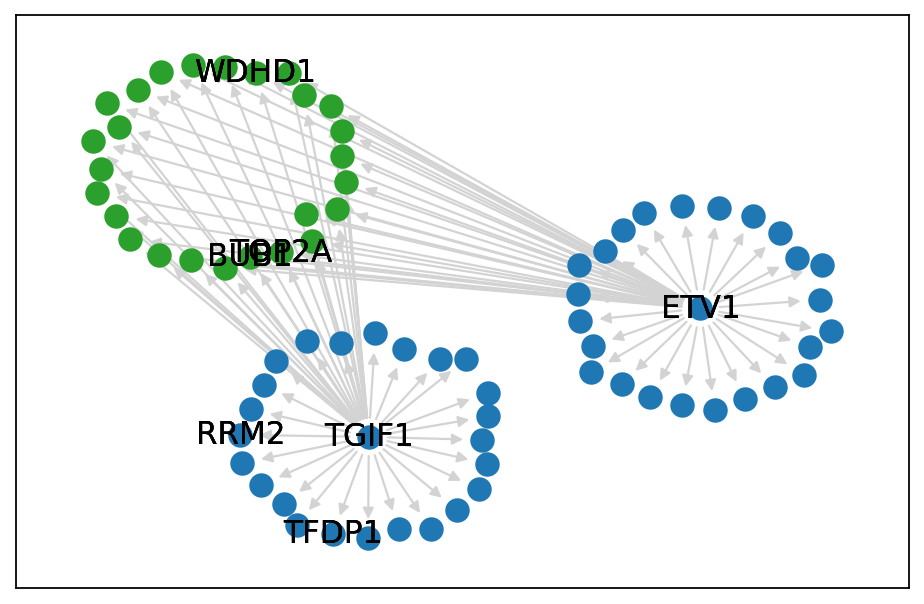

In [27]:
if SAVE_FIGURES:
    fig, ax = plt.subplots(figsize=(6,4))
    supergraph = nx.cycle_graph(len(communities))
    superpos = nx.spring_layout(G, scale=3)

    # Use the "supernode" positions as the center of each node cluster
    centers = list(superpos.values())
    pos = {}
    for center, comm in zip(centers, communities):
        pos.update(nx.spring_layout(nx.subgraph(G, comm), center=center))

    # Nodes colored by cluster
    node_list = ["TGIF1","ETV1","BUB1","TOP2A","RRM2","WDHD1","TFDP1"]
    for nodes, clr in zip(communities, ("tab:blue", "tab:blue", "tab:green")):
        nx.draw_networkx_nodes(G, pos=pos, nodelist=nodes, node_color=clr, node_size=100)
        nx.draw_networkx_labels(G, pos=pos, labels={node: node for node in node_list}, font_size=14, font_color='black')
    nx.draw_networkx_edges(G, pos=pos,edge_color='lightgrey')

    plt.tight_layout()

    fig.savefig(
                FIG_DIR / "cell_cycle" / "O2SC_GRN.svg",
                format="svg",
                transparent=True,
                bbox_inches='tight'
            )
    plt.show()